<a href="https://colab.research.google.com/github/poliduckie/poliduckie_pipeline/blob/master/notebooks/poliduckie_mpc_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PoliDuckies
A notebook with the complete pipeline

### Standard imports

In [1]:
import os 
branch = "master" #@param ['master', 'daffy']
if branch == "daffy":
  !pip install duckietown-gym-daffy
else:
  if not os.path.isdir('gym-duckietown') and not os.path.isdir('../gym-duckietown'):
    !git clone --branch {branch} https://github.com/duckietown/gym-duckietown.git
    !pip3 install -e gym-duckietown
  if "/gym-duckietown" not in os.getcwd():
    os.chdir('gym-duckietown')
!apt install xvfb -y
!pip3 install pyvirtualdisplay
!pip install pyglet==1.5.14
!pip install duckietown-gym-daffy

from pyvirtualdisplay import Display
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
%matplotlib inline

## used to copy the model to the gdrive folder
import shutil

import cv2
import gym
import gym_duckietown

# Gym has a built in logger to log information. The information is split in importance levels, from highest to lowest:
# CRITICAL, ERROR, WARNING, INFO, DEBUG, NOTSET
# To stop gym from printing many verbose NOTSET, INFO and DEBUG messages we let it print only level WARNING or higher messages
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

!pip install poliduckie-segmentation

Cloning into 'gym-duckietown'...
remote: Enumerating objects: 6237, done.
remote: Counting objects: 100% (448/448), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 6237 (delta 438), reused 427 (delta 427), pack-reused 5789
Receiving objects: 100% (6237/6237), 79.13 MiB | 27.04 MiB/s, done.
Resolving deltas: 100% (3601/3601), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/gym-duckietown
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Reading package lists

In [2]:
!pip install poliduckie-segmentation==0.1.16

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
map_name = "Duckietown-small_loop-v0"

### Methods

In [4]:
from poliduckie_segmentation.segmentation import Segmentation
def segmentation(image):
  """
    Returns the image from the simulation with the segmentation

    Image: np.Array
    ------
    Image: np.Array
  """
  resized = cv2.resize(image, (320, 240))
  seg = Segmentation()
  return seg.predict(resized)

In [5]:
from poliduckie_segmentation.line_extraction import LineExtraction
def lineExtraction(image, n_points=100, mode="bezier", bezier_degree=3):
  """
    Returns the central line extracted as a numpy array. The mode can be either "bezier" or "spline"

    Image: np.Array
    n_points: int
    mode: str
    bezier_degree: int
    ------
    Line: np.Array
  """
  lineExtraction_ = LineExtraction()
  x, y, pca = lineExtraction_.extract_centroids(image)

  if mode == "bezier":
    bezier_points = lineExtraction_.bezier_fit(x, y)
    return bezier_points
  
  elif mode == "spline":
    spline_points = lineExtraction_.spline_interpolation(image, n_points=n_points)
    return spline_points

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
def computeReference(line, N):
  """
    Returns the references in meters
    Reference is a list with dimension (2, N)
    N is the prediction horizon of the MPC

    Line: np.Array
    N: int
    ------
    reference: List[[List[Float], List[Float]]]
  """
  # extract x, y of reference
  # TODO

  reference = [[x]*N, [y]*N]
  pass

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
from poliduckie_segmentation.control import MPC
M = MPC()

def runMpc(state, reference):
  """
    Returns the control inputs to give to the car.
    State is [x, y, theta, v, w]
    Reference is a list with dimension (2, N)

    state: [Float, Float, Float, Float, Float]
    reference: List[[List[Float], List[Float]]]
    ------
    u: List[Float, Float]
  """
  return M.mpc(state, reference)

In [8]:
from google.colab.patches import cv2_imshow

### Simulation

In [9]:
display = Display(visible=0, size=(1400, 900))
display.start()
env = gym.make(map_name)
env.reset()

DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /usr/local/lib/python3.9/dist-packages
/usr/local/lib/python3.9/dist-packages/contracts/library/array_ops.py:225: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'np_int': np.int,  # Platform integer (normally either int32 or int64)
/usr/local/lib/python3.9/dist-packages/contracts/library/array_ops.py:234: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this wi

array([[[157, 187,  78],
        [157, 187,  78],
        [157, 187,  78],
        ...,
        [157, 187,  78],
        [157, 187,  78],
        [157, 187,  78]],

       [[157, 187,  78],
        [157, 187,  78],
        [157, 187,  78],
        ...,
        [157, 187,  78],
        [157, 187,  78],
        [157, 187,  78]],

       [[157, 187,  78],
        [157, 187,  78],
        [157, 187,  78],
        ...,
        [157, 187,  78],
        [157, 187,  78],
        [157, 187,  78]],

       ...,

       [[ 45,  47,  39],
        [ 45,  47,  39],
        [ 45,  47,  39],
        ...,
        [174, 181, 169],
        [174, 181, 169],
        [174, 181, 169]],

       [[ 44,  46,  38],
        [ 44,  46,  39],
        [ 44,  45,  38],
        ...,
        [174, 181, 169],
        [175, 182, 170],
        [174, 181, 169]],

       [[ 44,  45,  37],
        [ 43,  45,  37],
        [ 43,  45,  37],
        ...,
        [173, 180, 168],
        [174, 181, 169],
        [174, 181, 169]]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


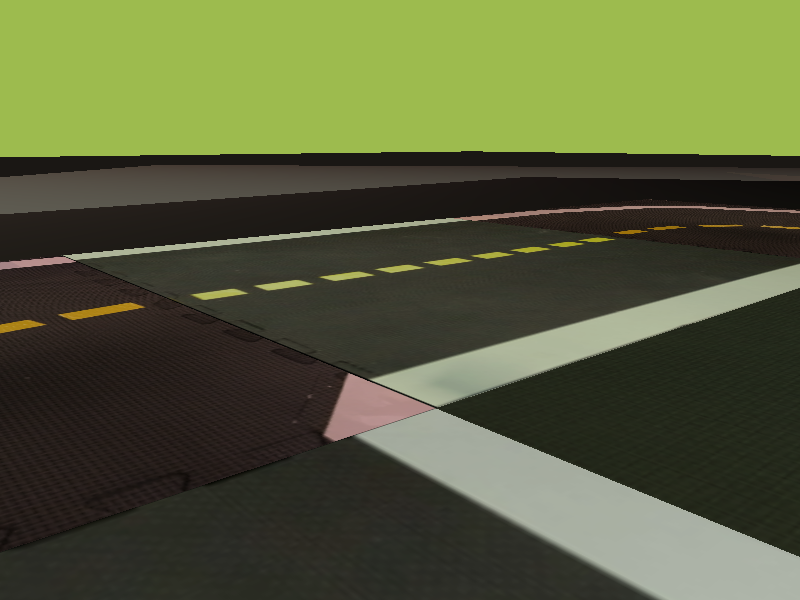

(600, 800, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 240, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 320, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                

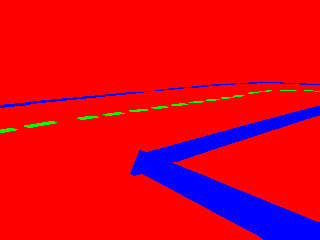

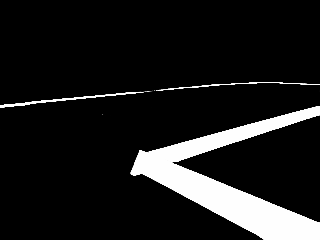

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ValueError: ignored

In [14]:
from poliduckie_segmentation.model import Model

# State X = [x, y, angle, longitudinal speed, angular speed]
state = [0,0,0,0,0]

F = Model()

image_recording = []

for _ in range(100):
  image = env.render(mode="rgb_array")
  image = np.concatenate([np.expand_dims(image[:,:,2],axis=-1),np.expand_dims(image[:,:,1],axis=-1),np.expand_dims(image[:,:,0],axis=-1)], axis=2)
  cv2_imshow(image)
  print(image.shape)

  image_recording.append(image)
  image_segmentation = segmentation(image)[0]*255
  cv2_imshow(image_segmentation)

  image_segmentation = image_segmentation[:, :, 0]
  cv2_imshow(image_segmentation)

  line = lineExtraction(image_segmentation)
  reference = computeReference(line)
  action = runMpc(state, reference)
  state = F.step(*state, action)
  env.step(action)